In [1]:
!pip install pandas
!pip install matplotlib

  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 58.5 MB/s eta 0:00:00a 0:00:01
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 31.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 20.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 55.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/10

In [2]:
# importing all packages
import pandas as pd
import gzip
import re
from urllib.parse import urlparse, parse_qsl, unquote
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import datetime 
%matplotlib inline

In [4]:
import os
print(os.getcwd())

/Users/balajialwar/Documents


In [5]:
# opens up the nbgitpuller file - uses gzip to open so need to ensure that file is zipped
nbgitpuller_filepath = 'nbgitpuller-clicks-sp24.jsonl.gz'
#nbgitpuller_filepath_sp24 = '/home/jovyan/admins-shared/nbgitpuller-clicks-sp24.jsonl.gz'
nbgitpuller_df = pd.read_json(gzip.open(nbgitpuller_filepath), lines = True)
nbgitpuller_df.head()

,insertId,labels,logName,receiveTimestamp,resource,severity,textPayload,timestamp
0,d7glsol1fvg2svws,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2024-01-01T00:07:55.593978082Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2024-01-01 00:07:54.724 JupyterHub log:191]...,2024-01-01 00:07:54.724992258+00:00
1,7s5v23jxoue1nzer,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2024-01-01T00:10:25.734174299Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2024-01-01 00:10:20.788 JupyterHub log:191]...,2024-01-01 00:10:20.788998544+00:00
2,wd6kh7msgy3fyerd,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2024-01-01T00:12:00.632416388Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2024-01-01 00:11:55.866 JupyterHub log:191]...,2024-01-01 00:11:55.866726106+00:00
3,bfmoozgmerhfx1bb,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2024-01-01T00:12:20.672804534Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2024-01-01 00:12:20.267 JupyterHub log:191]...,2024-01-01 00:12:20.267523710+00:00
4,vhepnqw8the0znbr,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2024-01-01T00:12:35.688733589Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2024-01-01 00:12:33.480 JupyterHub log:191]...,2024-01-01 00:12:33.481075150+00:00


# All File Types

In [6]:
# obtaining substring after GET and before the redirection
urls_all = nbgitpuller_df.textPayload.apply(lambda x: x[x.find('GET')+3:x.find('->')].strip())

# uses urllib.parse to parse the url into path and query
urls_parsed_all = urls_all.apply(lambda x: urlparse(x))

# uses the parsed urls to obtain the action from the path
nbgitpuller_df['actions'] = urls_parsed_all.apply(lambda x: os.path.basename(x.path))

In [7]:
nbgitpuller_df.actions.unique()

array(['git-pull', 'git-sync', 'interact'], dtype=object)

## For git-pull

In [11]:
# function to determine the filetypes
def path_extension_puller(row):
    """
    pandas row function; uses apply
    function to pull out select file extensions and urlpaths
    """
    row_dict = dict(row)
    if 'urlpath' in row_dict:
        key = 'urlpath'
    elif 'subPath' in row_dict:
        key = 'subPath'
    else: 
        return 'NaN', 'NaN'
    
    # files that the analysis is interested in 
    file_extension_list = ['ipyn[b]?', 'Rmd', 'pdf', 'txt', 'xml', 'ini', 'csv', 'py', 'R', 'md']
    if len(row_dict[key].split('.')) > 1:
        file_extension_split_string = row_dict[key].split('.')[-1]
        for file_extension in file_extension_list:
            if (len(re.findall(file_extension, file_extension_split_string)) > 0):
                return row_dict[key], re.findall(file_extension, file_extension_split_string)[-1]
        else:
            return row_dict[key], 'NaN'
    else:
            return row_dict[key], 'NaN'

def get_repo(row):
    """
    pandas row function; uses apply
    returns repo url from parsed url
    """
    for item in row:
        key, value = item
        if 'repo' in key:
            return unquote(value)
    return 'NaN'

def repo_parsing(row):
    """
    pandas row function; uses apply
    parses the repo url so that it obtains the user and folder/content user is accessing
    """
    if row:
        if len(row[0].split('/')) > 2:
            return row[0].split('/')[1]
        else:
            return row[0].split('/')[-1]
    else:
        return 'NaN'

In [12]:
# makes a new dataframe that only contains git-pull and resets index
nbgitpuller_df_pull = nbgitpuller_df[nbgitpuller_df.actions == 'git-pull'].reset_index()

# obtains all the log info
log_info_pull = nbgitpuller_df_pull.textPayload.apply(lambda x: ''.join(re.findall("\[.*\]", x)).replace('[', '').replace(']', '').split(' '))

# retreives the hubs for each textpayload
hub_source_pull = nbgitpuller_df_pull.resource.apply(lambda x: x['labels']['namespace_name'])

# obtains substring after GET and before the redirection
urls_pull = nbgitpuller_df_pull.textPayload.apply(lambda x: x[x.find('GET')+3:x.find('->')].strip())

# uses urllib.parse to parse the url into path and query
urls_parsed_pull = urls_pull.apply(lambda x: urlparse(x))

# uses parsed urls to obtain the action as a quality check
actions_pull = urls_parsed_pull.apply(lambda x: os.path.basename(x.path))

# breaks apart the parsed query into repo/urlpath
urls_queries_pull = urls_parsed_pull.apply(lambda x: parse_qsl(x.query))

# getting the file type from urlpath
path_extension_pull = urls_queries_pull.apply(path_extension_puller)

# gets repo urls from the parsed url
repos_pull = urls_queries_pull.apply(get_repo)

# extract ones that have github.com in the repo url or else its a null value
repos_parsed_pull = repos_pull.apply(lambda x: re.findall("github\.com/+(.+)", x) if x else 'NaN')

# obtains the user and git content from github.com repo urls
git_user_pull = repos_parsed_pull.apply(lambda x: x[0].split('/')[0] if x else 'NaN')
git_user_repo_pull = repos_parsed_pull.apply(repo_parsing)

# adds it all into a dataframe
nbgitpuller_textPayload_df_pull = pd.DataFrame({'log_info_type': log_info_pull.apply(lambda x: x[0]),
                                           'timestamp_date': log_info_pull.apply(lambda x: x[1]),
                                           'timestamp_time': log_info_pull.apply(lambda x: x[2]),
                                           'action': actions_pull,
                                           'git_query': urls_queries_pull,
                                           'repo': repos_pull,
                                           'git_user_content': repos_parsed_pull,
                                           'git_user': git_user_pull,
                                           'git_content': git_user_repo_pull,
                                           'git_path': path_extension_pull.apply(lambda x: x[0]),
                                           'file_extension': path_extension_pull.apply(lambda x: x[1]),
                                           'hub': hub_source_pull})

In [13]:
nbgitpuller_textPayload_df_pull['git_user_content_path'] = nbgitpuller_textPayload_df_pull.apply(lambda x: ''.join(x['git_user_content']) + '/' + ''.join(x['git_path']), axis = 1)


In [37]:
    nbgitpuller_textPayload_df_pull['course'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(lambda row: re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower())

    courses = {
        r'(ee120|eleng120)': 'eleng120',
        r'(physics111b)': 'physics111b',
        r'(physics88)': 'physics88',
        r'(polsci3|ps3|polisci3)': 'polsci3',
        r'(polsci5|ps5)': 'polsci5',
        r'(polsci88|ps88)': 'polsci88',
        r'(ps109|polsci109)': 'polsci109',
        r'(ce190|civeng90)': 'civgeng190',
        r'(ce93|civeng93)': 'civeng93',
        r'(ce110|civeng110)': 'civeng110',
        r'(envecon118|eep118)': 'envecon118',
        r'(eep147|envecon147)': 'envecon147',
        r'(eep153|envecon153)': 'envecon153',
        r'ph[w]?142': 'pbhlth142',
        r'ph[w]?251': 'pbhlth251',
        r'ph[w]?290': 'pbhlth290',
        r'ph[w]?252': 'pbhlth252',
        r'ph[w]?253': 'pbhlth253',
        r'pbhlth250c': 'pbhlth250c',
        r'ph[w]?196': 'pbhlth196',
        r'mcb163l': 'mcellbi163l',
        r'mcb280': 'mcellbi280',
        r'mcbc117': 'mcellbic117',
        r'mcb32': 'mcellbi32',
        r'mcb288': 'mcellbi288',
        r'(bio1b|biology1b)': 'biology1b',
        r'stat88': 'stat88',
        r'stat157': 'stat157',
        r'stat159': 'stat159',
        r'stat131': 'stat131',
        r'stat135': 'stat135',
        r'stat20': 'stat20',
        r'stat150': 'stat150',
        r'math124': 'math124',
        r'(demog180)': 'demog180',
        r'demog[c]?175': 'demog175',
        r'(eps130)': 'eps130',
        r'(eps88)': 'eps88',
        r'eps256': 'eps256',
        r'eps24': 'eps24',
        r'(econ140)': 'econ140',
        r'(econ148)': 'econ148',
        r'econ141': 'econ141',
        r'econ172': 'econ172',
        r'econ151': 'econ151',
        r'econ157': 'econ157',
        r'econ130': 'econ130',
        r'econ143': 'econ143',
        r'econ135': 'econ135',
        r'(rbridge)': 'datasci_rbridge',
        r'(midsw241)': 'datasci241',
        r'(midsw203)': 'datasci203',
        r'(legal123|legalst123)': 'legalst123',
        r'(legalst190|legal190)': 'legalst190',
        r'(es22ac|ethstd22ac)': 'ethstd22ac',
        r'(esc164a|ethstdc164a)': 'ethstdc164a',
        r'(es21ac|ethstd21ac)': 'ethstd21ac',
        r'cp201b': 'cyplan201b',
        r'(cityplanning88|cp88)': 'cyplan88',
        r'ib120': 'integbi120',
        r'ibc32': 'integbi32',
        r'ib134l': 'integbi134l',
        r'mse104l': 'matsci104l',
        r'are212': 'aresec212',
        r'educw142': 'educw142',
        r'(cogscic131|psych123)': 'cogscic131',
        r'psych198': 'psych198',
        r'anth[ro]?115': 'anthro115',
        r'espmc167': 'espmc167',
        r'(ibespm105)': 'espmc105',
        r'ls88': 'ls88',
        r'dighum101': 'dighum101',
        r'dighum160': 'dighum160',
        r'plantbi135': 'plantbi135',
        r'hist160': 'history160',
        r'soc88': 'sociol88',
        r'sw282': 'socwel282',
        r'music30': 'music30',
        r'artw23ac': 'artw23ac'
    }

    git_content_user = {
        r'danielabrahamgit120': 'eleng120',
        r'evalencialopezw142': 'educw142',
        r'charismasacey[A-Za-z0-9]+cp201': 'cp201a'
    }
    nbgitpuller_textPayload_df_pull['course'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(lambda row: re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower())

    for key in courses:
        if re.findall(key, nbgitpuller_textPayload_df_pull['course'].str):
            nbgitpuller_textPayload_df_pull['course'] = courses[key]
            break

    for key in git_content_user:
        if re.findall(key, nbgitpuller_textPayload_df_pull['course'].str):
            nbgitpuller_textPayload_df_pull['course'] = git_content_user[key]
            break


TypeError: expected string or bytes-like object, got 'StringMethods'

In [33]:
# assigns classes/courses to each log


In [34]:
def semester_assigner_regex(row):
    """
    pandas row function; uses apply
    returns the semester of the course material if known
    """
    semester = [r'fa[ll]*\d{1,4}', r'su[mmer]*\d{1,4}', r'sp[ring]*\d{1,4}', r'\d{1,4}fa[ll]', r'\d{1,4}su[mmer]*', r'\d{1,4}sp[ring]*']
    sem_match_dict = {'sp': 'spring', 'fa': 'fall', 'su':'summer'}

    git_string_cleaned = re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower()

    year_range = [2018, datetime.datetime.now().year]

    for sem in semester:
        try:
            if re.findall(sem, git_string_cleaned):
                sem_match = re.findall(sem, git_string_cleaned)[-1]
                sem_match_split = re.split('(\d+)', sem_match)
                sem_char = re.findall('[a-z]+', sem_match)[-1]
                sem_year = re.findall('[0-9]+', sem_match)[-1]
                for key, value in sem_match_dict.items():
                    if key in sem_char and sem_match_split[-1] == '':
                        if len(sem_year) < 4:
                            if year_range[0] <= int(f'20{sem_year[-2:]}') <= year_range[1]:
                                return f'{value}20{sem_year[-2:]}'
                            else:
                                return 
                        elif len(sem_year) == 4:
                            if year_range[0] <= int(sem_year) <= year_range[1]:
                                return f'{value}{sem_year}'
                            else:
                                return 'unknown'
                    elif key in sem_char and sem_match_split[-1] != '':
                        if year_range[0] <= int(sem_year) <= year_range[1]:
                            return f'{value}{sem_year}'
                        else:
                            return 'unknown'
        except Exception as e:
            print(f"Failed findall: {e=} {sem=} {git_string_cleaned=}")
            continue
    else:
        return 'unknown'


In [35]:
# assigns a semester to each log
nbgitpuller_textPayload_df_pull['semester'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(semester_assigner_regex)

KeyboardInterrupt: 

In [13]:
# transforms timestamp into one and converts from UTC to PST
nbgitpuller_textPayload_df_pull['timestamp_date_time_pst'] = pd.to_datetime(nbgitpuller_textPayload_df_pull.timestamp_date + ' ' + nbgitpuller_textPayload_df_pull.timestamp_time) - pd.Timedelta(8, unit = 'h')

In [14]:
# for ones that have NaN as their filetype, check if git_path contains r_studio
nbgitpuller_textPayload_df_pull['file_extension'] = nbgitpuller_textPayload_df_pull.apply(lambda x: 'rstudio' if 'rstudio' in x['git_path'] else x['file_extension'], axis = 1)

In [15]:
# determines if the links are github or non-github
nbgitpuller_textPayload_df_pull['abnormal'] = nbgitpuller_textPayload_df_pull.repo.apply(lambda x: 'N' if 'github.com' in x else 'Y')

In [16]:
nbgitpuller_textPayload_df_pull.head()

,log_info_type,timestamp_date,timestamp_time,action,git_query,repo,git_user_content,git_user,git_content,git_path,file_extension,hub,git_user_content_path,course,semester,timestamp_date_time_pst,abnormal
0,I,2023-08-01,00:01:27.148,git-pull,"[(repo, https://github.com/DS-100/su23-materia...",https://github.com/DS-100/su23-materials,[DS-100/su23-materials],DS-100,su23-materials,tree/su23-materials/lec/lec20/lec20.ipynb,ipynb,data100-jl4-prod,DS-100/su23-materials/tree/su23-materials/lec/...,data100,summer2023,2023-07-31 16:01:27.148,N
1,I,2023-08-01,00:02:25.420,git-pull,"[(repo, https://github.com/DS-100/su23-materia...",https://github.com/DS-100/su23-materials,[DS-100/su23-materials],DS-100,su23-materials,lab/tree/su23-materials/proj/projB1/projB1.ipynb,ipynb,data100-jl4-prod,DS-100/su23-materials/lab/tree/su23-materials/...,data100,summer2023,2023-07-31 16:02:25.420,N
2,I,2023-08-01,00:03:05.098,git-pull,"[(repo, https://github.com/ph142-ucb/ph142-su2...",https://github.com/ph142-ucb/ph142-su23,[ph142-ucb/ph142-su23],ph142-ucb,ph142-su23,rstudio/,rstudio,publichealth-prod,ph142-ucb/ph142-su23/rstudio/,pbhlth142,summer2023,2023-07-31 16:03:05.098,N
3,I,2023-08-01,00:03:40.613,git-pull,"[(repo, https://github.com/data-8/materials-su...",https://github.com/data-8/materials-su23,[data-8/materials-su23],data-8,materials-su23,retro/tree/materials-su23/materials/lab/lab10/...,ipynb,data8-prod,data-8/materials-su23/retro/tree/materials-su2...,data8,summer2023,2023-07-31 16:03:40.613,N
4,I,2023-08-01,00:04:06.994,git-pull,"[(repo, https://github.com/data-8/materials-su...",https://github.com/data-8/materials-su23,[data-8/materials-su23],data-8,materials-su23,retro/tree/materials-su23/materials/lab/lab11/...,ipynb,data8-prod,data-8/materials-su23/retro/tree/materials-su2...,data8,summer2023,2023-07-31 16:04:06.994,N


In [17]:
# separates abnormal repos 
nbgitpuller_textPayload_df_pull_abnormal = nbgitpuller_textPayload_df_pull[nbgitpuller_textPayload_df_pull.abnormal == 'Y']
nbgitpuller_textPayload_df_pull_normal = nbgitpuller_textPayload_df_pull[nbgitpuller_textPayload_df_pull.abnormal == 'N']

## Graph and Visualizations

### Ideas for Visualizations
1. Clicks by hub
2. What times people are accessing the hubs
3. File types across hubs
4. Semester usage of hubs

### Github Repos

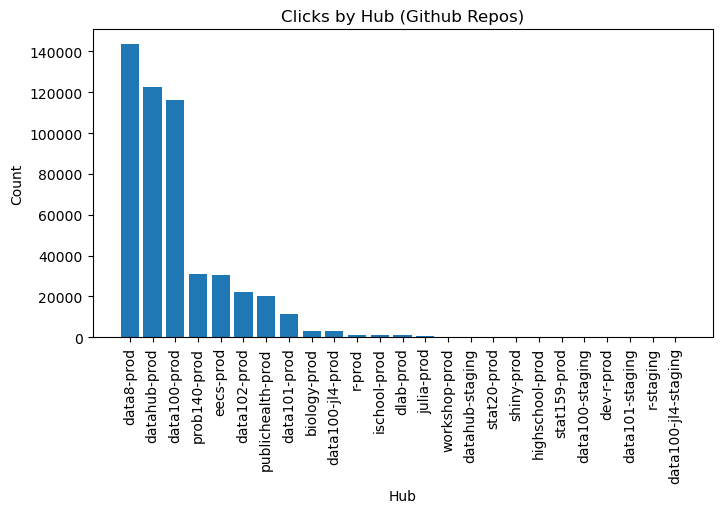

In [18]:
# clicks by hub for normal
clicks_by_hub = nbgitpuller_textPayload_df_pull_normal.hub.value_counts()
fig = plt.figure(figsize = (8,4))
plt.bar(clicks_by_hub.index, clicks_by_hub)
plt.xlabel('Hub')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Clicks by Hub (Github Repos)');

Text(0.5, 1.0, 'Clicks By Hub (Percentage) - Github Repos')

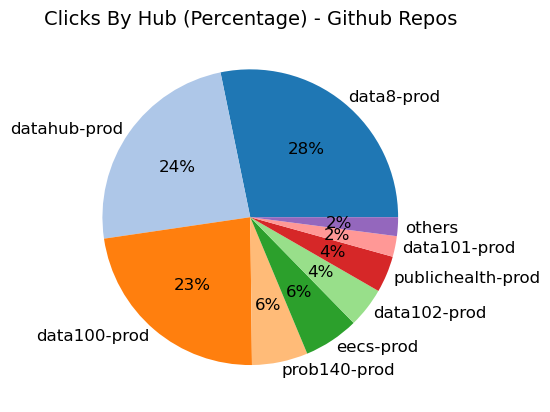

In [19]:
# clicks by hub pie chart
# only take the top 8 and then add the rest
clicks_by_hub_top8 = dict(clicks_by_hub[:8])
fig = plt.figure()
cm = plt.get_cmap('tab20')
num_colors = 9
clicks_by_hub_top8['others'] = clicks_by_hub[8:].sum()
clicks_by_hub_top8_df = pd.DataFrame(clicks_by_hub_top8.items(), columns = ['hub', 'counts'])
plt.pie(clicks_by_hub_top8_df.counts, labels = clicks_by_hub_top8_df.hub, autopct='%1.0f%%', textprops={'fontsize': 12, 'color': 'k'}, labeldistance= 1.05, colors= [cm(i) for i in range(num_colors)])
plt.title('Clicks By Hub (Percentage) - Github Repos', fontsize = 14, color = 'k')


In [20]:
fig.savefig("../images/hub_pie.png", transparent = True)

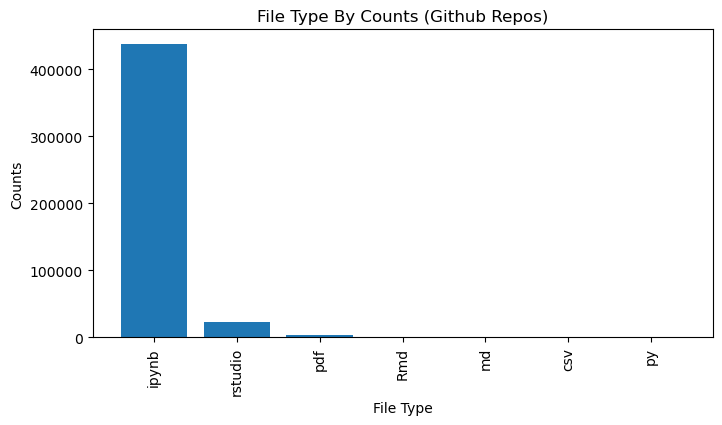

In [21]:
# filetypes; removed NaN counts; github repos
file_types_count = nbgitpuller_textPayload_df_pull_normal.file_extension[nbgitpuller_textPayload_df_pull_normal.file_extension != 'NaN'].value_counts()
fig = plt.figure(figsize=(8,4))
plt.bar(file_types_count.index, file_types_count)
plt.xticks(rotation=90)
plt.xlabel('File Type')
plt.ylabel('Counts')
plt.title('File Type By Counts (Github Repos)');

In [22]:
# filetypes across hubs
hubs = nbgitpuller_textPayload_df_pull_normal.hub.unique()
total_plots = len(hubs)
total_columns = 4
total_rows = math.ceil(total_plots/total_columns)

for k in range(total_plots):
    hub_file_filter_count = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.hub == hubs[k]].file_extension.value_counts().tolist()
    hub_file_filter_proportion = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.hub == hubs[k]].file_extension.value_counts(normalize = True).mul(100).round(2).tolist()
    hub_file_filter_key = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.hub == hubs[k]].file_extension.value_counts().keys().tolist()
    hub_file_filter_df = pd.DataFrame(data = {'file_type': hub_file_filter_key, 'counts': hub_file_filter_count, 'proportions': hub_file_filter_proportion})
    hub_file_filter_df['count_proportion'] = hub_file_filter_df['counts'].astype(str) + ' (' + hub_file_filter_df['proportions'].astype(str) + ')'
    hub_file_filter_df.drop(columns = ['counts', 'proportions'], inplace = True)
    print(hubs[k])
    print(hub_file_filter_df)

# for ax in axes.flatten():
#     if not ax.get_visible():
#         ax.set_axis_off()

data100-jl4-prod
  file_type count_proportion
0     ipynb     2944 (98.04)
1       NaN        59 (1.96)
publichealth-prod
  file_type count_proportion
0   rstudio    20339 (99.96)
1       NaN         9 (0.04)
data8-prod
  file_type count_proportion
0     ipynb   143508 (99.94)
1       NaN        80 (0.06)
prob140-prod
  file_type count_proportion
0     ipynb    31053 (99.87)
1       NaN        41 (0.13)
datahub-prod
  file_type count_proportion
0     ipynb   109678 (89.49)
1       NaN     12029 (9.82)
2       Rmd       425 (0.35)
3       pdf       148 (0.12)
4   rstudio        121 (0.1)
5        md        96 (0.08)
6       csv        57 (0.05)
7        py          1 (0.0)
data100-prod
  file_type count_proportion
0     ipynb   114435 (98.41)
1       NaN      1849 (1.59)
data102-prod
  file_type count_proportion
0     ipynb    17601 (79.17)
1       pdf      2913 (13.1)
2       NaN      1717 (7.72)
eecs-prod
  file_type count_proportion
0       NaN    26304 (85.87)
1     ipynb     4330 (

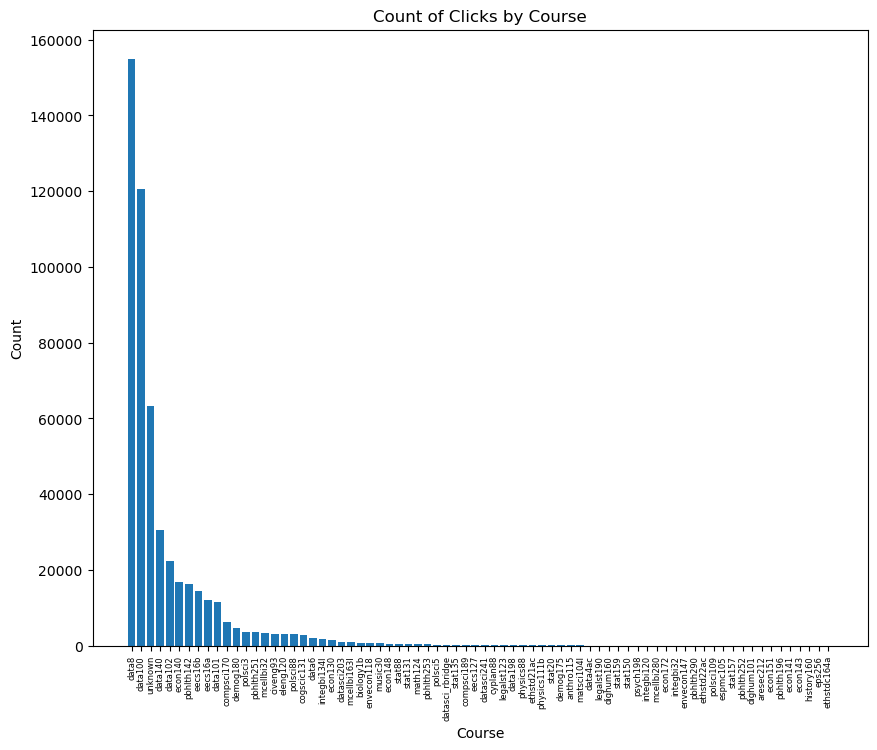

In [23]:
# looking at the classes
course_count = nbgitpuller_textPayload_df_pull_normal.course.value_counts()
figure = plt.figure(figsize = (10,8))
plt.bar(course_count.index, course_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Course')
plt.ylabel('Count')
plt.title('Count of Clicks by Course');

In [24]:
# top 10 of the courses
course_count.head(10)

course
data8        154879
data100      120524
unknown       63298
data140       30527
data102       22229
econ140       16910
pbhlth142     16142
eecs16b       14451
eecs16a       12050
data101       11498
Name: count, dtype: int64

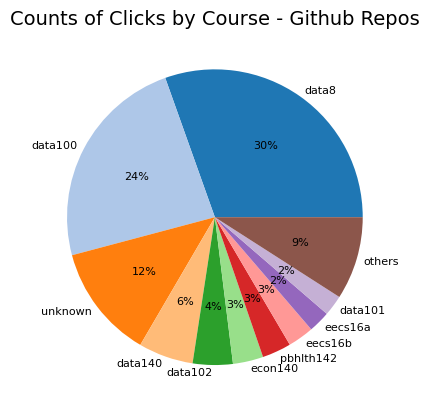

In [25]:
fig = plt.figure()
num_colors = 11
cm = plt.get_cmap('tab20')
courses_top10 = dict(course_count[:10])
courses_top10['others'] = course_count[10:].sum()
courses_top10_df = pd.DataFrame(courses_top10.items(), columns = ['course', 'counts'])
plt.pie(courses_top10_df.counts, labels = courses_top10_df.course, autopct='%1.0f%%', textprops={'fontsize': 8}, labeldistance= 1.05, 
        colors= [cm(i) for i in range(num_colors)])
plt.title('Counts of Clicks by Course - Github Repos', fontsize = 14);

In [26]:
fig.savefig("../images/course_pie.png",bbox_inches='tight', transparent = True)

In [27]:
courses_count_by_hub = nbgitpuller_textPayload_df_pull_normal.groupby('hub').course.value_counts()
courses_count_by_hub.to_csv('courses_count_by_hub.csv')

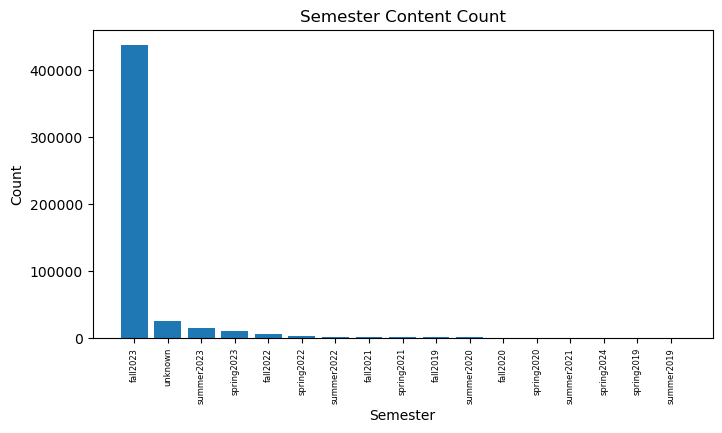

In [28]:
# looking at the semester usage 
sem_count = nbgitpuller_textPayload_df_pull_normal.semester.value_counts()
figure = plt.figure(figsize = (8,4))
plt.bar(sem_count.index, sem_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Semester')
plt.ylabel('Count')
plt.title('Semester Content Count');

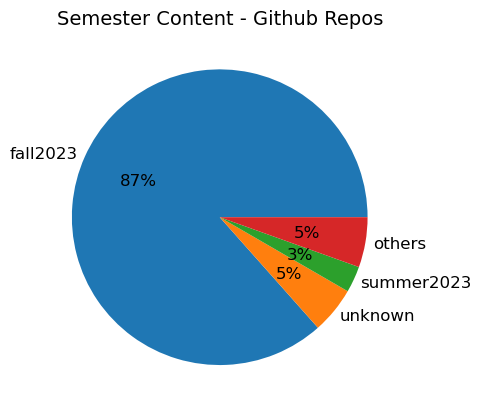

In [29]:
# looking at what times people access the hubs
fig = plt.figure()
num_colors = 4
cm = plt.get_cmap('tab10')
sem_top7 = dict(sem_count[:3])
sem_top7['others'] = sem_count[3:].sum()
sem_top7_df = pd.DataFrame(sem_top7.items(), columns = ['semester', 'counts'])
plt.pie(sem_top7_df.counts, labels = sem_top7_df.semester, autopct='%1.0f%%', textprops={'fontsize': 12}, labeldistance= 1.05, 
        colors= [cm(i) for i in range(num_colors)])
plt.title('Semester Content - Github Repos', fontsize = 14);

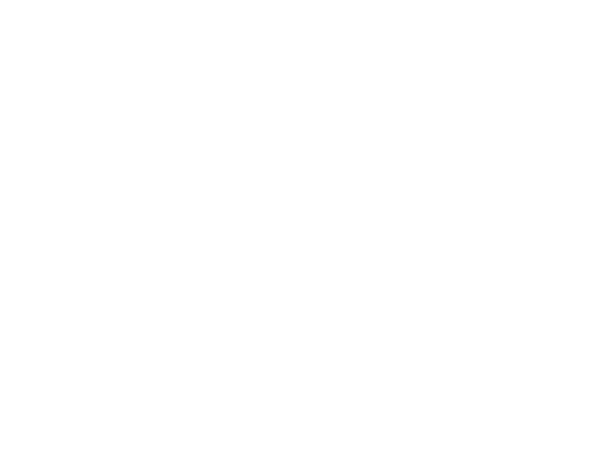

In [30]:
# looks at date of usage
date_usage = pd.DataFrame(nbgitpuller_textPayload_df_pull_normal.groupby(by = 'timestamp_date').timestamp_date.count())
date_usage.rename(columns = {'timestamp_date': 'count'}, inplace = True)
date_usage = date_usage.reset_index()
fig,ax = plt.subplots()
plt.bar(date_usage.timestamp_date, date_usage['count'], color = 'w')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.tick_params(axis ='x', colors = 'w')
ax.tick_params(axis ='y', colors = 'w')
plt.title('Usage by Date', color = 'w', fontsize = 12)
plt.xlabel('Date', color = 'w', fontsize = 12)
plt.ylabel('Frequency', color = 'w', fontsize = 12);

In [31]:
fig.savefig("../images/usage_bar.png",bbox_inches='tight', transparent = True)

IndexError: index 2 is out of bounds for axis 0 with size 2

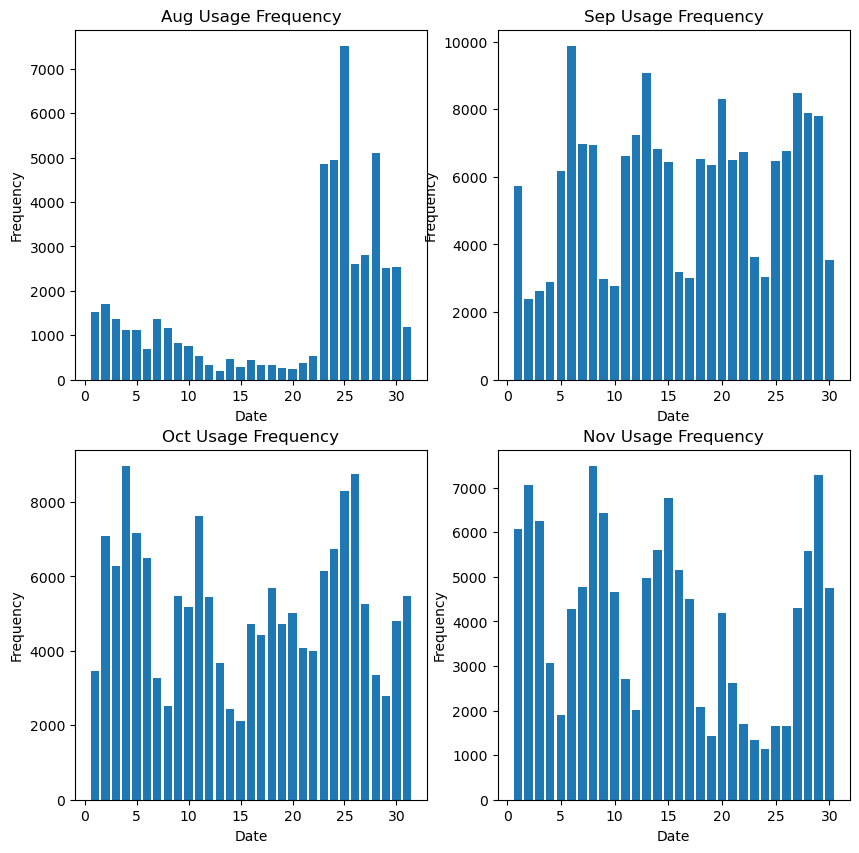

In [32]:
date_usage['timestamp_date'] = date_usage.timestamp_date.astype('datetime64[ns]')
date_usage['month'] = date_usage['timestamp_date'].apply(lambda x: x.month)
date_usage['day'] = date_usage['timestamp_date'].apply(lambda x: x.day)
unique_months = date_usage['month'].unique()
month_list = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

total_plots = len(unique_months)
total_columns = 2
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(10, 10))

for k in range(total_plots):
    month = date_usage[date_usage['month'] == unique_months[k]].reset_index()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(month['day'], month['count'])

    ax.set_title(f'{month_list[unique_months[k]]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')

axes[2,1].set_axis_off()
plt.tight_layout()

In [ ]:
nbgitpuller_textPayload_df_pull_normal.head()

In [ ]:
# looks at date of usage
nbgitpuller_textPayload_df_pull_normal['timestamp_time'] = pd.to_datetime(nbgitpuller_textPayload_df_pull_normal['timestamp_time'], format = '%H:%M:%S.%f')
nbgitpuller_textPayload_df_pull_normal['timestamp_time_hour'] = nbgitpuller_textPayload_df_pull_normal['timestamp_time'].apply(lambda x: x.hour)
usage_time = nbgitpuller_textPayload_df_pull_normal.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
usage_time = pd.DataFrame(usage_time)
usage_time.rename(columns = {'timestamp_time_hour': 'count'}, inplace = True)
usage_time = usage_time.reset_index()
fig,ax = plt.subplots()
plt.bar(usage_time.timestamp_time_hour, usage_time['count'], color = '#003262')
ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k')
ax.spines['left'].set_color('k')
ax.spines['right'].set_color('k')
ax.tick_params(axis ='x', colors = 'k')
ax.tick_params(axis ='y', colors = 'k')
plt.title('Usage by Time (UTC)', color = 'k')
plt.xlabel('Hour', color = 'k')
plt.ylabel('Frequency', color = 'k');

In [ ]:
fig.savefig("../images/time_usage_bar.png",bbox_inches='tight', transparent = True)

##### Making Graphs of Date of Usage Per Course

In [ ]:
# look at usage by courses 1-15
unique_courses = nbgitpuller_textPayload_df_pull_normal.course.unique()

# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at plots 16-30
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+15]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+15]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

In [ ]:
# look at plots 31-45
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+30]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+30]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

In [ ]:
# look at plots 45-60
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+45]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+45]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

In [ ]:
# look at plots 61-75
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+60]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+60]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

In [ ]:
# look at plots 76-90
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+75]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+75]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

In [ ]:
# look at plots 91-93
total_plots = 3
total_columns = 3
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(10, 3))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+90]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+90]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

##### Making Graphs of Time of Usage Per Course

In [ ]:
# look at usage time by courses 1-15
unique_courses = nbgitpuller_textPayload_df_pull_normal.course.unique()


# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15), sharex = False)
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at usage time by course 16-30
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+15]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+15]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at usage time by course 31 - 45
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+30]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+30]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at usage time by course 46 - 60
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+45]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+45]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at usage time by course 61 - 75
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+60]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+60]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at usage time by course 76 - 90
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+75]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+75]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

In [ ]:
# look at usage time by course 91-83
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 3
total_columns = 3
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(10, 5))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+90]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+90]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

### Non-Github Repos

In [ ]:
# clicks by hub for abnormal
clicks_by_hub = nbgitpuller_textPayload_df_pull_abnormal.hub.value_counts()
fig = plt.figure(figsize = (8,4))
plt.bar(clicks_by_hub.index, clicks_by_hub)
plt.xlabel('Hub')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Clicks By Hub (Non-Github Repos)');

In [ ]:
len(nbgitpuller_textPayload_df_pull.hub.unique())

In [ ]:
clicks_by_hub_top6 = dict(clicks_by_hub[:6])
clicks_by_hub_top6['others'] = clicks_by_hub[6:].sum()
clicks_by_hub_top6_df = pd.DataFrame(clicks_by_hub_top6.items(), columns = ['hub', 'counts'])
plt.pie(clicks_by_hub_top6_df.counts, labels = clicks_by_hub_top6_df.hub, autopct='%1.0f%%', textprops={'fontsize': 9}, labeldistance= 1.05)
plt.title('Clicks By Hub (Percentage) - Non-Github Repos');

In [ ]:
file_types_count = nbgitpuller_textPayload_df_pull_abnormal.file_extension[nbgitpuller_textPayload_df_pull_abnormal.file_extension != 'NaN'].value_counts()
fig = plt.figure(figsize=(8,4))
plt.bar(file_types_count.index, file_types_count)
plt.xticks(rotation=90)
plt.xlabel('File Type')
plt.ylabel('Counts')
plt.title('File Type By Counts (Non-Github Repos)');

In [ ]:
# filetypes across hubs
hubs = nbgitpuller_textPayload_df_pull_abnormal.hub.unique()
total_plots = len(hubs)
total_columns = 4
total_rows = math.ceil(total_plots/total_columns)

for k in range(total_plots):
    hub_file_filter_count = nbgitpuller_textPayload_df_pull_abnormal[nbgitpuller_textPayload_df_pull_abnormal.hub == hubs[k]].file_extension.value_counts().tolist()
    hub_file_filter_proportion = nbgitpuller_textPayload_df_pull_abnormal[nbgitpuller_textPayload_df_pull_abnormal.hub == hubs[k]].file_extension.value_counts(normalize = True).mul(100).round(2).tolist()
    hub_file_filter_key = nbgitpuller_textPayload_df_pull_abnormal[nbgitpuller_textPayload_df_pull_abnormal.hub == hubs[k]].file_extension.value_counts().keys().tolist()
    hub_file_filter_df = pd.DataFrame(data = {'file_type': hub_file_filter_key, 'counts': hub_file_filter_count, 'proportions': hub_file_filter_proportion})
    hub_file_filter_df['count_proportion'] = hub_file_filter_df['counts'].astype(str) + ' (' + hub_file_filter_df['proportions'].astype(str) + ')'
    hub_file_filter_df.drop(columns = ['counts', 'proportions'], inplace = True)
    print(hubs[k])
    print(hub_file_filter_df)

# for ax in axes.flatten():
#     if not ax.get_visible():
#         ax.set_axis_off()

In [ ]:
# looking at the classes
course_count = nbgitpuller_textPayload_df_pull_abnormal.course.value_counts()
figure = plt.figure(figsize = (8,4))
plt.bar(course_count.index, course_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Course')
plt.ylabel('Count')
plt.title('Count of Clicks by Course');

In [ ]:
# looking at the semester usage 
sem_count = nbgitpuller_textPayload_df_pull_abnormal.semester.value_counts()
figure = plt.figure(figsize = (8,4))
plt.bar(sem_count.index, sem_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Semester')
plt.ylabel('Count')
plt.title('Semester Content Count');